In [1]:
import Min_vertex_cover as mvc
import networkx as nx
import rustworkx as rx
import csv
import tensorflow as tf


import pennylane as qml
from pennylane.wires import Wires
from pennylane import numpy as np
from pennylane import qaoa


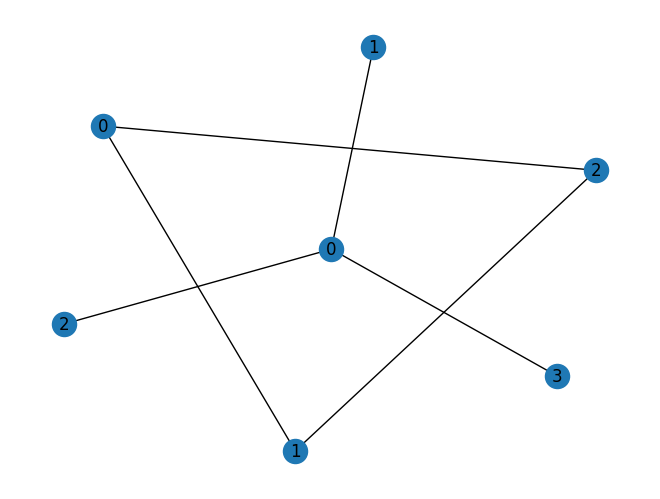

In [2]:
#edges = [(0,i) for i in range(1,4)]#,(2,3),(3,4)]
edges_m = [(0,1),(1,2),(2,0)]
edges_c = [(0,i) for i in range(1,4)]#,(2,3),(3,4)]
graph_m = nx.Graph(edges_m)
graph_c = nx.Graph(edges_c)
nx.draw(graph_m, with_labels=True)
nx.draw(graph_c, with_labels=True)

In [3]:
def qaoa_layer_m(gamma_m, beta_m):
    qaoa.cost_layer(gamma_m, cost_m)
    qaoa.mixer_layer(beta_m, mixer_m)

wires = range(len(graph_m.nodes())+len(graph_c.nodes()))
depth_m = 1

def circuit_m(params_m, **kwargs):
    #for w in wires:
        #qml.Hadamard(wires=w)
    qml.layer(qaoa_layer_m, depth_m, params_m[0],params_m[1])

dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function_m(params_m):
    circuit_m(params_m)
    return qml.expval(cost_m)


#def exp_values(cost_h,mixer_h):
#    bet   = np.arange(0,2*np.pi,0.01)
#    gam   = np.linspace(1,1,np.size(bet))
#    res   = []
#    for i in range(np.size(bet)):
#        params = np.array([[gam[i]],[bet[i]]])
#        res   += [cost_function(params)]
#    return res

In [4]:
#cost_h = mvc.cost_h(graph,1)
cost_m, mixer_m = qaoa.cost.max_independent_set(graph_m,constrained=True)
#mixer_m = mixer_h_1
#exp_value_1 = exp_values(cost_h,mixer_h_1)

In [5]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function_m(params_m):
    circuit_m(params_m)
    return qml.expval(cost_m)

In [6]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
params_m = np.array([[0.5], [3]], requires_grad=True)

In [7]:
for i in range(steps):
    params_m = optimizer.step(cost_function_m, params_m)

print("Optimal Parameters")
print(params_m)

Optimal Parameters
[[0.5       ]
 [2.01260566]]


In [8]:
@qml.qnode(dev)
def probability_circuit_m(gamma_m, alpha_m):
    circuit_m([gamma_m, alpha_m])
    return qml.probs(wires=wires)


probs = probability_circuit_m(params_m[0], params_m[1])

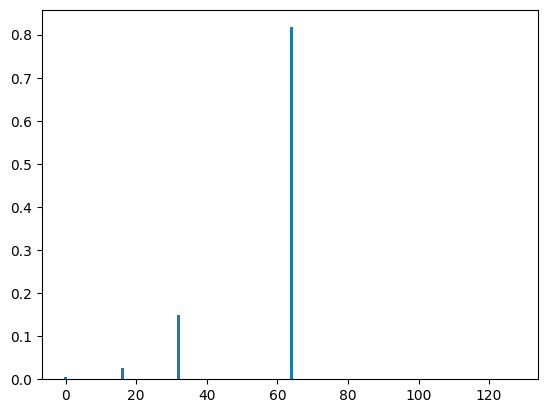

In [9]:
import matplotlib.pyplot as plt
plt.bar(range(2 ** len(wires)), probs)
plt.show()


In [10]:
np.argsort(probs)

tensor([ 63,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,
         79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,
         66,  65,  93, 126,  94,  97, 125, 124, 123, 122, 121, 120, 119,
        118, 117, 116, 115, 114, 113, 111, 110, 109, 108, 107, 106, 105,
        104, 103, 102, 101, 100,  99,  98,  95,  62, 127,  60,  29,  28,
         27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  61,  15,
         13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,
         14,  31,  30,  33,  59,  58,  57,  56,  55,  54,  53,  52,  51,
         50,  49,  47,  45,  46,  39,  34,  43,  42,  41,  40,  44,  38,
         37,  36,  35, 112,  48,  96,  80,   0,  16,  32,  64], requires_grad=True)

In [11]:
import itertools
import functools
from typing import Iterable, Union

import networkx as nx
import rustworkx as rx

import pennylane as qml
from pennylane.wires import Wires
from pennylane import numpy as np
from pennylane.qaoa.cost import bit_driver

def bit_flip_mixer_2_new(graph: Union[nx.Graph, rx.PyGraph], b: int, ofs:int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph object, got {type(graph).__name__}"
        )

    if b not in [0, 1]:
        raise ValueError(f"'b' must be either 0 or 1, got {b}")

    sign = 1 if b == 0 else -1

    coeffs = [1 for i in range(ofs)]
    terms = [qml.Identity(i) for i in range(ofs)]

    is_rx = isinstance(graph, rx.PyGraph)
    graph_nodes = graph.node_indexes() if is_rx else graph.nodes

    # In RX each node is assigned to an integer index starting from 0;
    # thus, we use the following lambda function to get node-values.
    get_nvalue = lambda i: graph.nodes()[i] if is_rx else i

    for u in graph_nodes:
        for v in graph_nodes:
            if u==v:
                i = u
                neighbours = sorted(graph.neighbors(i)) if is_rx else list(graph.neighbors(i))
                degree = len(neighbours)

                n_terms = [[qml.PauliX(get_nvalue(i)+ofs)]] + [
                    [qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours
                ]
                n_coeffs = [[1, sign] for n in neighbours]

                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            elif u < v and not graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v)))
                degree       = len(neighbours)
                n_terms      = [[qml.PauliX(get_nvalue(u)+ofs)@qml.PauliX(get_nvalue(v)+ofs)]] +[[qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
    
    return qml.Hamiltonian(coeffs, terms)

def cost_h_new(graph: Union[nx.Graph, rx.PyGraph],b: int, ofs: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph, got {type(graph).__name__}"
        )

    graph_nodes = range(ofs,len(graph.nodes())+ofs)
    cost_h = bit_driver(graph_nodes, 0)
    cost_h.grouping_indices = [list(range(len(cost_h.ops)))]
    return cost_h

In [1]:
def bit_flip_mixer_1_new(graph: Union[nx.Graph, rx.PyGraph], b: int,ofs: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph object, got {type(graph).__name__}"
        )

    if b not in [0, 1]:
        raise ValueError(f"'b' must be either 0 or 1, got {b}")

    sign = 1 if b == 0 else -1

    coeffs = [1 for _ in range(ofs)]
    terms = [qml.Identity(i) for i in range(ofs)]

    is_rx = isinstance(graph, rx.PyGraph)
    graph_nodes = graph.node_indexes() if is_rx else graph.nodes
    # In RX each node is assigned to an integer index starting from 0;
    # thus, we use the following lambda function to get node-values.
    get_nvalue = lambda i: graph.nodes()[i] if is_rx else i
    for i in graph_nodes:
        neighbours = sorted(graph.neighbors(i)) if is_rx else list(graph.neighbors(i))
        degree = len(neighbours)

        n_terms = [[qml.PauliX(get_nvalue(i)+ofs)]] + [
            [qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours
        ]
        n_coeffs = [[1, sign] for n in neighbours]

        final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
        final_coeffs = [
            (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
            for m in itertools.product(*n_coeffs)
        ]

        coeffs.extend(final_coeffs)
        terms.extend(final_terms)

    return qml.Hamiltonian(coeffs, terms)


NameError: name 'Union' is not defined

In [13]:
def bit_flip_mixer_3_new(graph: Union[nx.Graph, rx.PyGraph], b: int, ofs: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph object, got {type(graph).__name__}"
        )

    if b not in [0, 1]:
        raise ValueError(f"'b' must be either 0 or 1, got {b}")

    sign = 1 if b == 0 else -1

    coeffs = [1 for i in range(ofs)]
    terms = [qml.Identity(i) for i in range(ofs)]

    is_rx = isinstance(graph, rx.PyGraph)
    graph_nodes = graph.node_indexes() if is_rx else graph.nodes

    # In RX each node is assigned to an integer index starting from 0;
    # thus, we use the following lambda function to get node-values.
    get_nvalue = lambda i: graph.nodes()[i] if is_rx else i

    for u in graph_nodes:
        for v in graph_nodes:
            if u==v:
                i = u
                neighbours = sorted(graph.neighbors(i)) if is_rx else list(graph.neighbors(i))
                degree = len(neighbours)

                n_terms = [[qml.PauliX(get_nvalue(i)+ofs)]] + [
                    [qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours
                ]
                n_coeffs = [[1, sign] for n in neighbours]

                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            elif u < v and not graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v)))
                degree       = len(neighbours)
                n_terms      = [[qml.PauliX(get_nvalue(u)+ofs)@qml.PauliX(get_nvalue(v)+ofs)]] +[[qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            
            
            elif u < v and graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v))) 
                neighbours.remove(u)
                neighbours.remove(v)
                degree       = len(neighbours)
                
                
                n_terms      = [[qml.PauliX(get_nvalue(u)+ofs)@qml.PauliX(get_nvalue(v)+ofs)]] +[[qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**(degree+1)) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
                
                n_terms      = [[qml.PauliY(get_nvalue(u)+ofs)@qml.PauliY(get_nvalue(v)+ofs)]] +[[qml.Identity(get_nvalue(n)+ofs), qml.PauliZ(get_nvalue(n)+ofs)] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                  (0.5**(degree+1)) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            
                
    return qml.Hamiltonian(coeffs, terms)

In [14]:
print(bit_flip_mixer_3_new(graph_c,1,3))

  (0.125) [X3]
+ (0.5) [X4]
+ (0.5) [X5]
+ (0.5) [X6]
+ (1) [I0]
+ (1) [I1]
+ (1) [I2]
+ (-0.5) [X4 Z3]
+ (-0.5) [X5 Z3]
+ (-0.5) [X6 Z3]
+ (-0.125) [X3 Z6]
+ (-0.125) [X3 Z5]
+ (-0.125) [X3 Z4]
+ (0.125) [X3 X4]
+ (0.125) [Y3 Y4]
+ (0.125) [X3 X5]
+ (0.125) [Y3 Y5]
+ (0.125) [X3 X6]
+ (0.125) [Y3 Y6]
+ (0.5) [X4 X5]
+ (0.5) [X4 X6]
+ (0.5) [X5 X6]
+ (-0.5) [X4 X5 Z3]
+ (-0.5) [X4 X6 Z3]
+ (-0.5) [X5 X6 Z3]
+ (-0.125) [X3 X4 Z6]
+ (-0.125) [X3 X4 Z5]
+ (-0.125) [Y3 Y4 Z6]
+ (-0.125) [Y3 Y4 Z5]
+ (-0.125) [X3 X5 Z6]
+ (-0.125) [X3 X5 Z4]
+ (-0.125) [Y3 Y5 Z6]
+ (-0.125) [Y3 Y5 Z4]
+ (-0.125) [X3 X6 Z5]
+ (-0.125) [X3 X6 Z4]
+ (-0.125) [Y3 Y6 Z5]
+ (-0.125) [Y3 Y6 Z4]
+ (0.125) [X3 Z5 Z6]
+ (0.125) [X3 Z4 Z6]
+ (0.125) [X3 Z4 Z5]
+ (-0.125) [X3 Z4 Z5 Z6]
+ (0.125) [X3 X4 Z5 Z6]
+ (0.125) [Y3 Y4 Z5 Z6]
+ (0.125) [X3 X5 Z4 Z6]
+ (0.125) [Y3 Y5 Z4 Z6]
+ (0.125) [X3 X6 Z4 Z5]
+ (0.125) [Y3 Y6 Z4 Z5]


In [15]:
print(mvc.bit_flip_mixer_3(graph_c,1))

  (0.125) [X0]
+ (0.5) [X1]
+ (0.5) [X2]
+ (0.5) [X3]
+ (-0.5) [X1 Z0]
+ (-0.5) [X2 Z0]
+ (-0.5) [X3 Z0]
+ (-0.125) [X0 Z3]
+ (-0.125) [X0 Z2]
+ (-0.125) [X0 Z1]
+ (0.125) [X0 X1]
+ (0.125) [Y0 Y1]
+ (0.125) [X0 X2]
+ (0.125) [Y0 Y2]
+ (0.125) [X0 X3]
+ (0.125) [Y0 Y3]
+ (0.5) [X1 X2]
+ (0.5) [X1 X3]
+ (0.5) [X2 X3]
+ (-0.5) [X1 X2 Z0]
+ (-0.5) [X1 X3 Z0]
+ (-0.5) [X2 X3 Z0]
+ (-0.125) [X0 X1 Z3]
+ (-0.125) [X0 X1 Z2]
+ (-0.125) [Y0 Y1 Z3]
+ (-0.125) [Y0 Y1 Z2]
+ (-0.125) [X0 X2 Z3]
+ (-0.125) [X0 X2 Z1]
+ (-0.125) [Y0 Y2 Z3]
+ (-0.125) [Y0 Y2 Z1]
+ (-0.125) [X0 X3 Z2]
+ (-0.125) [X0 X3 Z1]
+ (-0.125) [Y0 Y3 Z2]
+ (-0.125) [Y0 Y3 Z1]
+ (0.125) [X0 Z2 Z3]
+ (0.125) [X0 Z1 Z3]
+ (0.125) [X0 Z1 Z2]
+ (-0.125) [X0 Z1 Z2 Z3]
+ (0.125) [X0 X1 Z2 Z3]
+ (0.125) [Y0 Y1 Z2 Z3]
+ (0.125) [X0 X2 Z1 Z3]
+ (0.125) [Y0 Y2 Z1 Z3]
+ (0.125) [X0 X3 Z1 Z2]
+ (0.125) [Y0 Y3 Z1 Z2]


In [23]:
cost_c = cost_h_new(graph_c,1,3)
mixer_c = bit_flip_mixer_new(graph_c,1,3)

NameError: name 'bit_flip_mixer_new' is not defined

In [ ]:
def qaoa_layer_c(gamma_c, beta_c):
    qaoa.cost_layer(gamma_c, cost_c)
    qaoa.mixer_layer(beta_c, mixer_c)

#wires = range(len(graph_m.nodes())+len(graph_c.nodes()))
depth_c = 3
def circuit_c(params_c, **kwargs):
    #for w in wires:
        #qml.Hadamard(wires=w)
    circuit_m(params_m)
    qml.CNOT([0,3])
    qml.CNOT([1,3])
    qml.CNOT([2,3])
    qml.CNOT([0,4])
    qml.CNOT([1,5])
    qml.CNOT([2,6])
    qml.layer(qaoa_layer_c, depth_c, params_c[0],params_c[1])

dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function_c(params_c):
    circuit_c(params_c)
    return qml.expval(cost_c)



In [24]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
params_c = np.array([[0.34001893,3,3], [6.10359477,6,6]], requires_grad=True)

In [25]:
for i in range(steps):
    params_c = optimizer.step(cost_function_c, params_c)

print("Optimal Parameters")
print(params_c)

@qml.qnode(dev)
def probability_circuit_c(gamma_c, alpha_c):
    circuit_c([gamma_c, alpha_c])
    return qml.probs(wires=wires)


probs = probability_circuit_c(params_c[0], params_c[1])

Optimal Parameters
[[0.34001893 2.89000556 2.76905995]
 [6.25933202 6.30531642 6.26529825]]


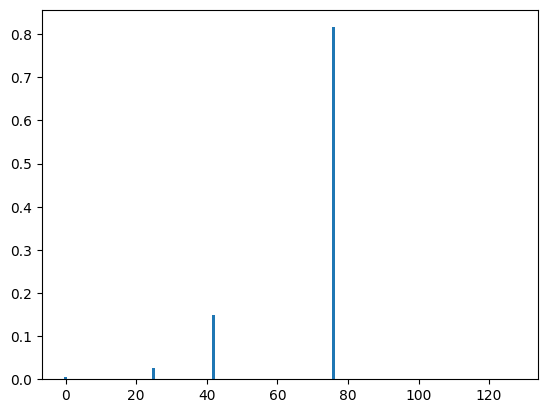

In [26]:
import matplotlib.pyplot as plt
plt.bar(range(2 ** len(wires)), probs)
plt.show()


In [27]:
np.argsort(probs)

tensor([ 98, 116, 113, 112, 114,  97,  52, 117, 115, 118,  82, 120, 124,
        122, 121, 126, 125, 123, 119,  99, 100, 101,  48,  96,  54,  49,
         50,  62,  60,  61,  81,  84, 109,  53, 107,  80, 105,  86,  55,
        103,  56, 104,  57, 127,  90,  87,  83,  91,  88,  94, 106,  63,
         58, 111,  59, 108, 110,  95,  93,  92,  89,   7,  13,   3,   5,
          2,   1,   4,  14,  11,   6,  15,  33,  37,  22,  18,  36,  10,
         66,  20,  12,  65,  17,   9,  67,   8,  21,  51,  32, 102,  16,
         69,  19,  35,  70,  34,  38,  85,  64,  68,  30,  45,  23,  75,
         39,  31,  71,  29,  27,  24,  47,  26,  28,  46,  43,  40,  79,
         41,  44,  78,  77,  72,  73,  74,   0,  25,  42,  76], requires_grad=True)

In [28]:
probs[72]

tensor(0.00012813, requires_grad=True)

In [61]:
bin(25)[-4:]

'1001'

In [62]:
bin(42)[-4:]

'1010'

In [63]:
bin(76)[-4:]

'1100'

In [70]:
cost_c = mvc.cost_h(graph_c,1)
mixer_c = mvc.bit_flip_mixer(graph_c,1)

In [40]:
e_hadamard = np.exp(1j*1/np.sqrt(2)*np.array([[1,1],[1,-1]]))

In [41]:
e_hadamard

tensor([[0.7602446+0.64963694j, 0.7602446+0.64963694j],
        [0.7602446+0.64963694j, 0.7602446-0.64963694j]], requires_grad=True)

In [71]:
a = qml.matrix(mixer_c).real

In [72]:
a.shape

(16, 16)

In [73]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

In [74]:
import scipy
q = scipy.linalg.expm(1j*a)
np.linalg.norm(q[6])

1.0

In [78]:
s = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])
p = np.matmul(q,s)

In [79]:
p[3]

tensor(0.+0.j, requires_grad=True)

In [139]:
def qaoa_layer_c(gamma_c, beta_c):
    qaoa.cost_layer(gamma_c, cost_c)
    qaoa.mixer_layer(beta_c, mixer_c)

wires = range(len(graph_c.nodes()))
d = 3
depth_c = d
def circuit_c(params_c, **kwargs):
    #for w in wires:
        #qml.Hadamard(wires=w)
    #circuit_m(params_m)
    #qml.CNOT([0,3])
    #qml.CNOT([1,3])
    #qml.CNOT([2,3])
    #qml.CNOT([0,4])
    #qml.CNOT([1,5])
    #qml.CNOT([2,6])
    #for w in wires:
    #    qml.PauliX(wires=w)
    qml.PauliX(wires = 0)
    qml.PauliX(wires = 2)
    qml.layer(qaoa_layer_c, depth_c, params_c[0],params_c[1])

dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function_c(params_c):
    circuit_c(params_c)
    return qml.expval(cost_c)



In [140]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
params_c = np.array([[2 for _ in range(d)], [2 for _ in range(d)]], requires_grad=True)

In [141]:
for i in range(steps):
    params_c = optimizer.step(cost_function_c, params_c)

print("Optimal Parameters")
print(params_c)

@qml.qnode(dev)
def probability_circuit_c(gamma_c, alpha_c):
    circuit_c([gamma_c, alpha_c])
    return qml.probs(wires=wires)


probs = probability_circuit_c(params_c[0], params_c[1])

Optimal Parameters
[[2.         2.08490963 2.23603684]
 [1.89658491 1.88706853 2.62789963]]


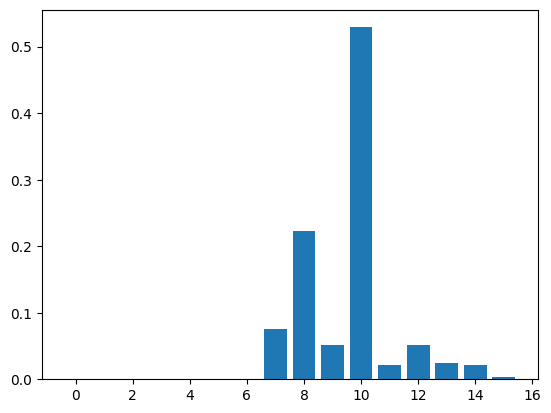

In [142]:
import matplotlib.pyplot as plt
plt.bar(range(2 ** len(wires)), probs)
plt.show()


In [143]:
print(bit_flip_mixer_2_new(graph_c,1,3))

  (0.125) [X3]
+ (0.5) [X4]
+ (0.5) [X5]
+ (0.5) [X6]
+ (1) [I0]
+ (1) [I1]
+ (1) [I2]
+ (-0.5) [X4 Z3]
+ (-0.5) [X5 Z3]
+ (-0.5) [X6 Z3]
+ (-0.125) [X3 Z6]
+ (-0.125) [X3 Z5]
+ (-0.125) [X3 Z4]
+ (0.5) [X4 X5]
+ (0.5) [X4 X6]
+ (0.5) [X5 X6]
+ (-0.5) [X4 X5 Z3]
+ (-0.5) [X4 X6 Z3]
+ (-0.5) [X5 X6 Z3]
+ (0.125) [X3 Z5 Z6]
+ (0.125) [X3 Z4 Z6]
+ (0.125) [X3 Z4 Z5]
+ (-0.125) [X3 Z4 Z5 Z6]


In [105]:
print(mvc.bit_flip_mixer_2(graph_c,1))

  (0.125) [X0]
+ (0.5) [X1]
+ (0.5) [X2]
+ (0.5) [X3]
+ (-0.5) [X1 Z0]
+ (-0.5) [X2 Z0]
+ (-0.5) [X3 Z0]
+ (-0.125) [X0 Z3]
+ (-0.125) [X0 Z2]
+ (-0.125) [X0 Z1]
+ (0.5) [X1 X2]
+ (0.5) [X1 X3]
+ (0.5) [X2 X3]
+ (-0.5) [X1 X2 Z0]
+ (-0.5) [X1 X3 Z0]
+ (-0.5) [X2 X3 Z0]
+ (0.125) [X0 Z2 Z3]
+ (0.125) [X0 Z1 Z3]
+ (0.125) [X0 Z1 Z2]
+ (-0.125) [X0 Z1 Z2 Z3]
